# FNLP: Lab Session 4

# Parsing

# Aim

The aims of this lab session are to introduce simple parser models and Context Free Grammars (CFGs) and to
explore and address the problem of syntactic ambiguity. By the end of this lab session, you should be able to:

* Access parsed treebank corpora provided in NLTK
* Step through the process of parsing a simple sentence using a simple CFG
* Understand why ambiguity can be a problem for parsing
* Implement simple models to resolve the problem of ambiguity
* Interpret a dependency parse and its relationship to a constituency parse

In [ ]:
### Import packages used for this lab

import nltk, cky

# Import nltk.tree and nltk.CFG
from nltk import tree, CFG

from cky import CKY, tokenise

from pprint import pprint as pp

import cfg_fix
from cfg_fix import parse_grammar

from nltk.app import rdparser_app as rd


def app(grammar, sent="we sleep"):
    """
    Create a recursive descent parser demo, using a simple grammar and
    text.
    
    :param grammar: The grammar to apply
    :type grammar: nltk.grammar.CFG
    :param sent: Text to parse
    :type sent: str"""
    rd.RecursiveDescentApp(grammar, sent.split()).mainloop()

# Introduction

This lab will introduce parsed corpora, parsing new data, the problems of ambiguity and syntactic agreement,
and using features to improve parsing.

#  Parsed Corpora

NLTK contains a number of corpora with parse trees already available – that is, someone has already constructed a
grammar, implemented a parser and produced parse trees for each sentence in the corpus. The Penn Treebank is an example of a parsed
corpus, produced by using human annotators to select from and augment the outputs of a tagger+parser. It contains several sub-corpora including the Wall Street Journal (WSJ) corpus, and uses the following
tagset: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

Import the portion of the WSJ corpus provided in NLTK:

In [ ]:
from nltk.corpus import treebank
# The treebank contains 199 articles:
len(treebank.fileids())

Each article contains a number of sentences, each of which has been parsed. The parsed sentences are provided
as a list of trees. Print out the first sentence of the first article:

In [ ]:
t = treebank.parsed_sents('wsj_0001.mrg')[0]
print(t)

Before proceeding to the next step, minimise all the other windows on your desktop.  It you don't see anything happen after running the next segment, minimise this notebook window too, and you should be able to see the tree display window.  When you've finished looking at it, close it, and if necessary re-expand the notebook window.

In [ ]:
# We can use nltk.tree to draw the trees, making them easier to read:
from nltk import tree
t.draw()

There are many more things that can be done with `nltk.tree`. The source code contains a “demo” section
which outlines some of these things. If you are interested in learning more about `nltk.tree` please visit:
http://www.nltk.org/_modules/nltk/tree.html

# Approaches to parsing CFGs

### Exercise 1

The code below runs an interactive parser over a toy grammar.

Look at it and make sure that you understand what each step does. Ask the
lab demonstrator if you are unsure.  Then run the code.

In [ ]:
#################### EXERCISE 1 ####################

def interactive_parsing_example():
    """Use a modified grammar to build a parser"""
    # Load the CFG grammar
    grammar = parse_grammar("""
        S -> NP VP
        PP -> P NP
        NP -> Det N | NP PP | 'I'
        VP -> V NP | VP PP
        Det -> 'an' | 'my'
        N -> 'elephant' | 'pyjamas'
        V -> 'shot'
        P -> 'in'
        """)

    # Print out the grammar rules, one line at a time
    # pp is a method in the "parse" module
    print("Grammar rules:")
    pp(grammar.productions())

    # Step through the parse (using a Recursive Descent / Top-down parser)
    print("Running interactive Recursive-Descent parser...")
    print("  Close the window to end execution")
    app(grammar,"I shot an elephant in my pyjamas")
    
interactive_parsing_example()

Look at the grammar rules that are printed above.

Now look at the parser app.  It runs in its own window, so as with the tree window above, you may have to move or minimise this notebook window in order to find the parser app.

Interactively step through the parsing of a sample sentence in the app:
  - Click the **Autostep** button and watch the parser step through
  - Do you notice a problem?
  - Click the **Autostep** button again to freeze the animation, then click in the tree window and hit the **Delete** key to reset the parser (or use the **Reset** entry in the **File** menu)
  - Click the **Step** button and look at the left column display and the frame just above the input sentence
    - These show the operation of the algorithm
  - **Step** repeatedly, resetting if necessary to start over, until you understand what's going on

Use the **Edit Grammar** entry in the **Edit** menu and replace the line: NP → Det N | NP PP | ’I’
with: NP → Det N | Det N PP | ’I’

Now re-run the parser using the new grammar.

**Question:** Can you explain why the parser is now able to parse the sentence?

Don’t reset or close the parser app just yet.

# Ambiguity

But, getting the grammar right isn’t our only problem. The sentence “I shot an elephant in my pyjamas” is
also ambiguous. Consider who is wearing the pyjamas – the elephant or the person doing the shooting.

You can see this by forcing the demo parser to backtrack and look for another parse: just click autostep after
it has found the first parse.

Here are the two possible parses of this sentence, depending on who is wearing the “pyjamas”, and arising from
structural ambiguity surrounding PP attachment:


```
                                                            S
                                                          /   \
(S                                                       /     \
  (NP I)                                                NP     VP  
  (VP                                                   |    /    \
     (V shot)                                           I   /      \
         (NP (Det an) (N elephant)                         /        \
             (PP (P in)                                   VP         PP
                 (NP (Det my) (N pyjamas))))))           /  \      /    \
                                                        /    \    /      \
                                                       Vt    NP   P      NP  
                                                       |    /  \  |     /  \
                                                     shot Det  N  in  Det  N
                                                           |   |       |   |
                                                          an elephant my pyjamas
                                                                    
                                                      S
(S                                                  /   \ 
  (NP I)                                           /     \
  (VP                                            NP       VP
     (VP (V shot) (NP (Det an) (N elephant)))    |      /   \
     (PP (P in) (NP (Det my) (N pyjamas)))))     I     /     \
                                                     Vt       NP
                                                      |     / |  \
                                                     shot  /  |   \
                                                          /   /    PP
                                                       Det   N   /  \
                                                       |     |   P   NP
                                                      /      /   |  /  \
                                                     an elephant in Det  N
                                                                     |   |
                                                                    my pyjamas
```

**Question**: Which parse reflects the elephant wearing the pyjamas and which reflects the person doing the
shooting wearing the pyjamas?

Now you can close the parser demo

# CKY parsing

### Exercise 2

A simple CKY parser is imported from `cky.py`. In this exercise you will explore how it implements the CKY algorithm.


In [ ]:
# A somewhat more detailed grammar for Exercise 2
grammar2 = parse_grammar([
"S -> Sdecl '.' | Simp '.' | Sq '?' ", # Take advantage of the punctuation
"Sdecl -> NP VP",
"Simp -> VP",
"Sq -> Sqyn | Swhadv",
"Sqyn -> Mod Sdecl | Aux Sdecl", # Re-use where we can
"Swhadv -> WhAdv Sqyn", # likewise
"Sc -> Subconj Sdecl", # For "that S"
"NP -> PropN | Pro | NP0 ", # NP that allows no modification
"NP0 -> NP1 | NP0 PP", # NP with (multiple) PP attachment
"NP1 -> Det N2sc | Det N2mp | N2mp | Sc", # Common nouns and sentential complements
"N2sc -> Adj N2sc | Nsc | N3 Nsc", # Adjectival mod, head noun for singular
                                   #  count nouns
"N2mp -> Adj N2mp | Nmp | N3 Nmp", # Adjectival mod, head noun for plural
                                   #  count nouns or mass nouns
"N3 -> N | N3 N", # Noun-noun compounds
"N -> Nsc | Nmp",
"VP -> VPi | VPt | VPdt | Mod VP | VP Adv | VP PP", # a bit of subcat,
                                                    # allows mixed Adv and PP
                                                    # modifications :-(
"VPi -> Vi", # intransitive
"VPt -> Vt NP", # transitive
"VPdt -> VPo PP", # ditransitive, obligatory NP (obj.) & PP complements
"VPdt -> VPio NP", # ditransitive, obligatory NP (iobj.) & NP (obj)
"VPo -> Vdt NP", # direct object of ditransitive
"VPio -> Vdt NP", # indirect obj. part of dative-shifted ditransitive
"PP -> Prep NP",
"Det -> 'a' | 'the' | 'an' | 'my'",
"Nmp -> 'salad' | 'mushrooms' | 'pyjamas'",  # mass nouns, plural count nouns
"Nsc -> 'book' | 'fork' | 'flight' | 'salad' | 'drawing' | 'elephant'", # singular count
"Prep -> 'to' | 'with' | 'in'",
"Vi -> 'ate'",
"Vt -> 'ate' | 'book' | 'Book' | 'gave' | 'told' | 'shot'",
"Vdt -> 'gave' | 'told' ",
"Subconj -> 'that'",
"Mod -> 'Can' | 'will'",
"Aux -> 'did' ",
"WhAdv -> 'Why'",
"PropN -> 'John' | 'Mary' | 'NYC' | 'London'",
"Adj -> 'nice' | 'drawing'",
"Pro -> 'you' | 'he' | 'I'",
"Adv -> 'today'"
])

chart = CKY(grammar2)

def test2_1(verbose=False):
    global chart
    s = "I ate salad."
    chart.parse(tokenise(s),verbose)
    print(str(chart.firstTree()))
    chart.pprint()

def test2_2(verbose=False):
    global chart
    s = "I shot an elephant in my pyjamas."
    parsed = chart.parse(tokenise(s),verbose)
    if parsed:
        for tree in chart.allTrees():
            print(str(tree))
            tree.draw()

Run the first call to `test2_1()` You’ll see both the parse and the completed CKY matrix.

In [ ]:
test2_1()

Look at the grammar, the matrix and the result and satisfy yourself that you know where each entry
in the matrix comes from, and where the backpointers must be to allow the parse to be reconstructed.


Now try calling `test2_1()` in verbose mode (verbose=True) so that the actions associated with each cell are shown. 

Again, inspect this and see that it confirms your earlier understanding.

In [ ]:
test2_1(True)

Finally, `try test2_2` to go back to our ambiguous sentence. As before, you may need to minimise and look around, and finally to close tree diagrams to get back to this notebook. You can see the underlying matrix by doing:
    
    chart.pprint()

You can go on to try other inputs by doing:

    chart.parse(tokenise("...")[,True])

In [ ]:
### Try the Groucho Marx sentence
test2_2()

In [ ]:
### Look at the matrix
chart.pprint()

What's the explanation for the **S&nbsp;**in cell 1,8?  What string does it assign the **S&nbsp;**to?  What is wrong with this?  What might be needed to fix it?

#  Dependencies


All the parses we’ve seen so far are constituency trees. An alternative way of representing syntactic structure
is with a dependency tree, in which nodes are words in the sentence and edges represent head-modifier
relationships. For instance, an unlabeled dependency parse of _I only eat the best apples_:

```
  eat
 / |  \
I only apples
       / |
     the best
```
The overall head of the sentence is typically the main verb—in this case, _eat_. Heads are connected by edges to their direct modifiers or arguments. Edges can further be decorated with labels indicating grammatical relations like **subject**, **direct object**, **adverbial modifier**, etc.

Dependency parsers can produce such trees either by rule-based conversion from constituency trees, or by
parsing directly into dependencies. The widely-used Stanford Parser is an example of the former strategy: it
constituency-parses, then converts to dependencies.

### Exercise 3

Stanford provide online access to their parser at http://nlp.stanford.edu:8080/corenlp/. It's not a very powerful server, so please do not try it during the lab, but you can try it later if you like.  We've used it to parse the sentence “I shot an elephant in my pajamas.”, you can see the results below. Look at the output displayed under “Basic Dependencies”.
Refer to http://universaldependencies.org/en/dep/ for descriptions of the edge labels.
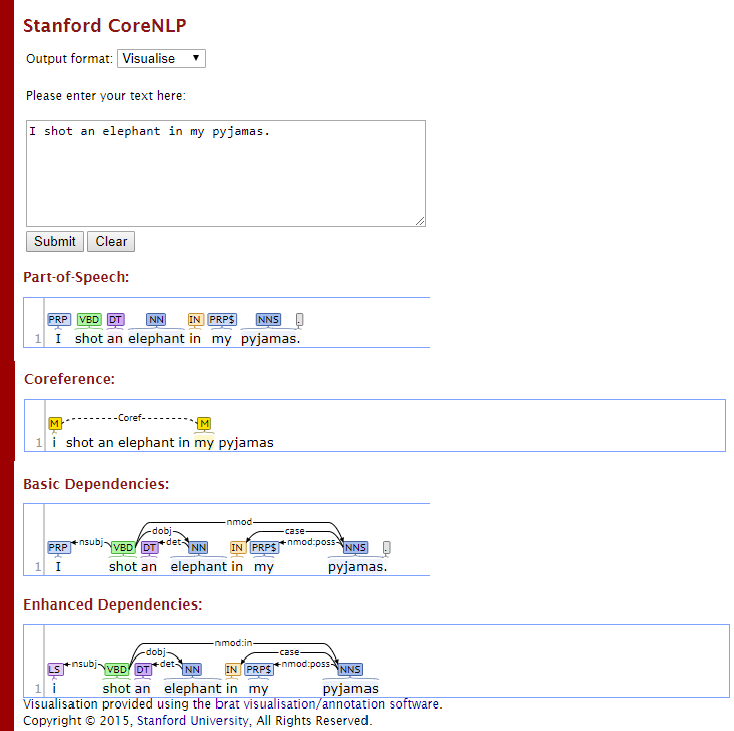

Which way is the ambiguity resolved?  That is, which of the constituency parses from Exercise 2 does the Stanford
dependency parse correspond to? How would the dependency parse differ for the other reading of the sentence?

### Exercise 4

Give the productions needed for the second (‘correct’ but not funny) constituency tree from Exercise 1 (see
[**Ambiguity**](#Ambiguity) above). On the right-hand side of each rule, identify the one nonterminal whose constituent contains the head of the rule according to the dependency parse. We've done the first one for you:

 - S -> NP **VP**
 - PP -> P NP
 - NP -> Det N | NP PP | 'I'
 - VP -> V NP | VP PP

(To mark the rules in this notebook, double-click inside the section with the rules just above, put `**`s around the symbols you want to make bold, then hold down **Shift** while hitting **Enter**)

VP is bold because S covers the entire sentence, and the yield of VP contains the verb, which is the overall
head of the sentence. Do you see how identifying these head-containing constituents (achieved in practice with
heuristics known as head rules) leads to a deterministic transformation from the constituency parse to the
dependency parse?